In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

In [2]:
data = pd.read_csv("/kaggle/input/severstal-steel-defect-detection/train.csv")

res = pd.read_csv('/kaggle/input/steel-data/submission.csv')
res.to_csv('submission.csv', index=False)

In [3]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [4]:
data.shape

(7095, 3)

**Wr have 7095 observations and 3 features.**

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

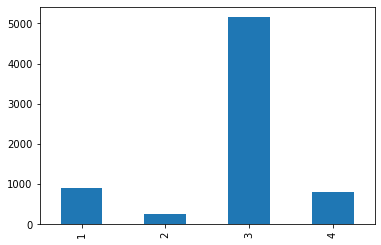

In [5]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

**ClassID 3 has the maximum count among other classid's.**

**Image Augmentation**

In [6]:
l1=[]
l2=[] 
for img,ClassId,EncodedPixels in tqdm(data.values):
    image=cv2.imread("/kaggle/input/severstal-steel-defect-detection/train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)

100%|██████████| 7095/7095 [02:13<00:00, 53.16it/s]


**Checking Random Steel images to check whether it is defected or not**

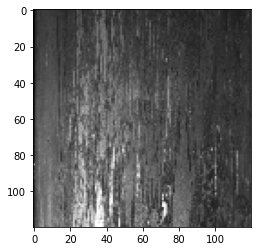

In [7]:
i = 15
plt.imshow(l1[i])

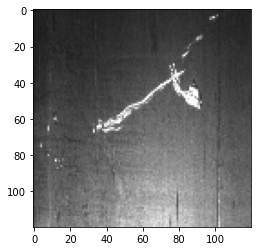

In [8]:
i = 16
plt.imshow(l1[i])

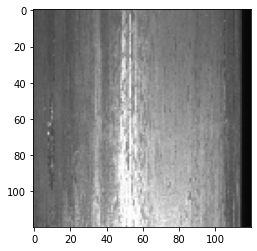

In [9]:
i = 90
plt.imshow(l1[i])

**Label encoding the input features and one hot encoding the target feature.**

In [10]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)


In [11]:
X.shape

(7095, 120, 120, 3)

In [12]:
y.shape

(7095,)

In [13]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X , y)
X = X.reshape(-1,120,120,3)

In [14]:
X.shape

(20600, 120, 120, 3)

In [15]:

y = to_categorical(y)

In [16]:
y

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

**Splitting the data into 80% train set and 20% test set**

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [18]:
print("x_train shape:",X_train.shape)
print("x_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (16480, 120, 120, 3)
x_test shape: (4120, 120, 120, 3)
y_train shape: (16480, 4)
y_test shape: (4120, 4)


**Building the CNN Model**

In [19]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

In [20]:
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

**Compiling the model**

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

**Fitting the model**

In [22]:
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/20
129/129 [==============================] - 134s 1s/step - loss: 1.1559 - accuracy: 0.4454 - val_loss: 0.8549 - val_accuracy: 0.6701
Epoch 2/20
129/129 [==============================] - 131s 1s/step - loss: 0.8217 - accuracy: 0.6551 - val_loss: 0.7519 - val_accuracy: 0.6852
Epoch 3/20
129/129 [==============================] - 144s 1s/step - loss: 0.7118 - accuracy: 0.7173 - val_loss: 0.6255 - val_accuracy: 0.7597
Epoch 4/20
129/129 [==============================] - 136s 1s/step - loss: 0.6233 - accuracy: 0.7575 - val_loss: 0.5936 - val_accuracy: 0.7680
Epoch 5/20
129/129 [==============================] - 139s 1s/step - loss: 0.5566 - accuracy: 0.7837 - val_loss: 0.5255 - val_accuracy: 0.8083
Epoch 6/20
129/129 [==============================] - 139s 1s/step - loss: 0.4922 - accuracy: 0.8158 - val_loss: 0.4706 - val_accuracy: 0.8245
Epoch 7/20
129/129 [==============================] - 137s 1s/step - loss: 0.4387 - accuracy: 0.8365 - val_loss: 0.4520 - val_accuracy: 0.8405

<AxesSubplot:title={'center':'Loss curve'}>

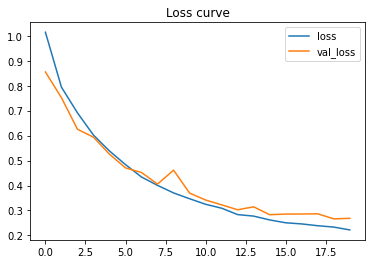

In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<AxesSubplot:title={'center':'Accuracy curve'}>

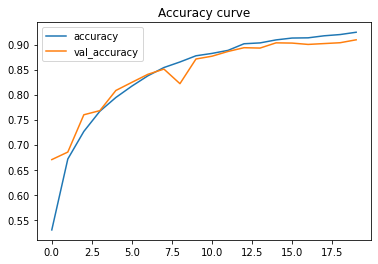

In [24]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [25]:
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

129/129 [==============================] - 9s 69ms/step - loss: 0.2685 - accuracy: 0.9095
[+] Accuracy: 90.95%
